# Iniciando sessão do PySpark

In [240]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 40)
sns.set(style="white")
mpl.rc('font', family='Calibri')

In [64]:
# Iniciando o ambiente PySpark
import findspark
findspark.init()

In [65]:
# Criando uma instância de SparkSession para iniciar uma sessão Spark
from pyspark.sql import SparkSession

spark = SparkSession\
    .builder\
    .master('local[*]')\
    .appName('Análise de dados do SIA')\
    .config('spark.ui.port', '4050')\
    .getOrCreate()

# Carregando Dataset do SIA

In [66]:
PATH_FINAL_DATASET = r'data\003_JOIN_DATASETS\FINAL_DATASET'

In [67]:
df = spark.read.parquet(PATH_FINAL_DATASET)
df.limit(5).toPandas()

,PA_SG_PROC_ID,PA_G_PROC_ID,PA_PROC_ID,PA_CBOCOD,PA_NIVCPL,PA_UFMUN,PA_OBITO,PA_ENCERR,PA_PERMAN,PA_ALTA,PA_TRANSF,PA_QTDAPR,PA_VALAPR,PA_UFDIF,PA_MNDIF,PA_CMP,DS_PA_UFMUN,DS_PA_NIVCPL,DS_PA_CBOCOD,DS_PA_PROC_ID,DS_PA_G_PROC_ID,DS_PA_SG_PROC_ID
0,202,2,202010317,225250,2,261160,0,0,0,0,0,1,1.85,9,9,2023-05-01,RECIFE,Média Complexidade,Medico ginecologista e obstetra,DOSAGEM DE CREATININA,Procedimentos com finalidade diagnóstica,Diagnóstico em laboratório clínico
1,301,3,301080356,251510,2,260680,0,0,1,0,0,1,0.00,0,0,2023-05-01,IGARASSU,Média Complexidade,Psicologo clinico,PROMOCAO DE CONTRATUALIDADE NO TERRITORIO,Procedimentos clínicos,Consultas / Atendimentos / Acompanhamentos
2,202,2,202010317,225250,2,261160,0,0,0,0,0,2,3.70,9,9,2023-05-01,RECIFE,Média Complexidade,Medico ginecologista e obstetra,DOSAGEM DE CREATININA,Procedimentos com finalidade diagnóstica,Diagnóstico em laboratório clínico
3,301,3,301080356,251510,2,260680,0,0,1,0,0,1,0.00,0,0,2023-05-01,IGARASSU,Média Complexidade,Psicologo clinico,PROMOCAO DE CONTRATUALIDADE NO TERRITORIO,Procedimentos clínicos,Consultas / Atendimentos / Acompanhamentos
4,202,2,202010317,225250,2,261160,0,0,0,0,0,2,3.70,9,9,2023-05-01,RECIFE,Média Complexidade,Medico ginecologista e obstetra,DOSAGEM DE CREATININA,Procedimentos com finalidade diagnóstica,Diagnóstico em laboratório clínico


In [68]:
df.printSchema()

root
 |-- PA_SG_PROC_ID: integer (nullable = true)
 |-- PA_G_PROC_ID: integer (nullable = true)
 |-- PA_PROC_ID: integer (nullable = true)
 |-- PA_CBOCOD: string (nullable = true)
 |-- PA_NIVCPL: integer (nullable = true)
 |-- PA_UFMUN: integer (nullable = true)
 |-- PA_OBITO: integer (nullable = true)
 |-- PA_ENCERR: integer (nullable = true)
 |-- PA_PERMAN: integer (nullable = true)
 |-- PA_ALTA: integer (nullable = true)
 |-- PA_TRANSF: integer (nullable = true)
 |-- PA_QTDAPR: integer (nullable = true)
 |-- PA_VALAPR: double (nullable = true)
 |-- PA_UFDIF: integer (nullable = true)
 |-- PA_MNDIF: integer (nullable = true)
 |-- PA_CMP: date (nullable = true)
 |-- DS_PA_UFMUN: string (nullable = true)
 |-- DS_PA_NIVCPL: string (nullable = true)
 |-- DS_PA_CBOCOD: string (nullable = true)
 |-- DS_PA_PROC_ID: string (nullable = true)
 |-- DS_PA_G_PROC_ID: string (nullable = true)
 |-- DS_PA_SG_PROC_ID: string (nullable = true)



In [69]:
# Criando uma view para executar comandos SQL
df.createOrReplaceTempView("VW_SIA")

In [70]:
SQL_QTD_PROC = ''' 
SELECT PA_SG_PROC_ID
     , EXTRACT(YEAR FROM PA_CMP) AS ANO
     , COUNT(1)
     , SUM(PA_QTDAPR)
 FROM VW_SIA
WHERE PA_SG_PROC_ID = '101'
GROUP BY PA_SG_PROC_ID, EXTRACT(YEAR FROM PA_CMP)
ORDER BY 2
'''

spark.sql(SQL_QTD_PROC).toPandas()

,PA_SG_PROC_ID,ANO,count(1),sum(PA_QTDAPR)
0,101,2020,16,2389
1,101,2021,43381,6122869
2,101,2022,56817,6205134
3,101,2023,49597,3899337


In [71]:
SQL_TEMP = ''' 
SELECT 'DS_PA_UFMUN', COUNT(1) QT_NULL
  FROM VW_SIA
 WHERE DS_PA_UFMUN IS NULL
 UNION ALL 
SELECT 'DS_PA_NIVCPL', COUNT(1) QT_NULL
  FROM VW_SIA
 WHERE DS_PA_NIVCPL IS NULL
 UNION ALL 
SELECT 'DS_PA_CBOCOD', COUNT(1) QT_NULL
  FROM VW_SIA
 WHERE DS_PA_CBOCOD IS NULL
 UNION ALL 
SELECT 'DS_PA_PROC_ID', COUNT(1) QT_NULL
  FROM VW_SIA
 WHERE DS_PA_PROC_ID IS NULL
 UNION ALL 
SELECT 'DS_PA_G_PROC_ID', COUNT(1) QT_NULL
  FROM VW_SIA
 WHERE DS_PA_G_PROC_ID IS NULL
 UNION ALL 
SELECT 'DS_PA_SG_PROC_ID', COUNT(1) QT_NULL
  FROM VW_SIA
 WHERE DS_PA_SG_PROC_ID IS NULL
'''

spark.sql(SQL_TEMP).toPandas()

,DS_PA_UFMUN,QT_NULL
0,DS_PA_UFMUN,0
1,DS_PA_NIVCPL,0
2,DS_PA_CBOCOD,8881
3,DS_PA_PROC_ID,0
4,DS_PA_G_PROC_ID,0
5,DS_PA_SG_PROC_ID,0


In [81]:
spark.sql('''SELECT PA_CBOCOD, DS_PA_CBOCOD
               FROM VW_SIA
              WHERE 1=1
                AND DS_PA_CBOCOD IS NULL
                AND PA_CBOCOD IS NOT NULL''').toPandas()

,PA_CBOCOD,DS_PA_CBOCOD


# Desafio 1: Análise do SIA em Pernambuco: Procedimentos, Complexidade e Profissionais

Gráfico de Barras de Procedimentos por Tipo de Profissional: Crie um gráfico de barras que mostre a contagem de procedimentos realizados por diferentes tipos de profissionais de saúde. Isso pode ajudar a identificar se há procedimentos realizados por profissionais não especializados.

In [73]:
# Quantidade de procedimentos distintos realizados por profissional
SQL_101 = '''
SELECT PA_CBOCOD
     , DS_PA_CBOCOD
     , COUNT(PA_PROC_ID) AS QTD_PROC_REALIZADOS
  FROM (
       SELECT PA_CBOCOD
            , DS_PA_CBOCOD
            , PA_PROC_ID
            , DS_PA_PROC_ID
            , COUNT(1)
         FROM VW_SIA
        GROUP BY PA_CBOCOD
              , DS_PA_CBOCOD
              , PA_PROC_ID
              , DS_PA_PROC_ID
       )
 GROUP BY PA_CBOCOD
        , DS_PA_CBOCOD
 ORDER BY COUNT(PA_PROC_ID) DESC
'''

O gráfico de barras horizontais revela que o Médico Clínico é o profissional de saúde com o maior número de procedimentos distintos realizados, liderando a lista com 722 procedimentos. Logo em seguida, o Médico em Radiologia e Diagnóstico por Imagem e os Biomédicos também desempenham um papel significativo, com 537 e 533 procedimentos, respectivamente. A lista abrange diversas especializações médicas, como cardiologia, ginecologia e obstetrícia, oftalmologia, infectologia e neurologia. Esses dados fornecem uma visão inicial da distribuição da carga de trabalho entre os profissionais de saúde.

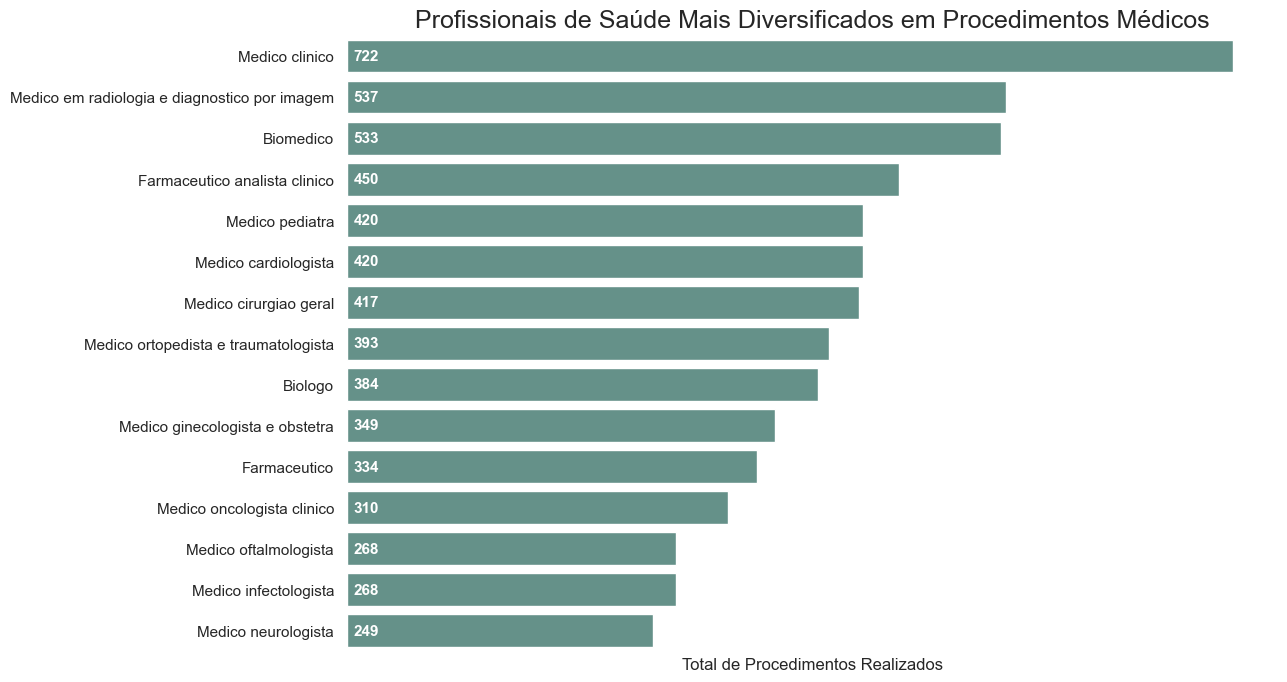

In [74]:
num_results = 15

sns.set_style("whitegrid", {  'axes.spines.bottom': False, 'axes.spines.left': False
                            , 'axes.spines.right': False, 'axes.spines.top': False})

plt.figure(figsize=(12, 8))

ax = sns.barplot(x="QTD_PROC_REALIZADOS", y="DS_PA_CBOCOD",
                 data=spark.sql(SQL_101).limit(num_results).toPandas(),
                 color='#5d998d')

ax.set(xticks=[])

for p in ax.patches:
    width = p.get_width()
    plt.text(5, p.get_y() + p.get_height() / 2, f"{int(width)}",
             ha="left", va="center", fontsize=11, fontweight="bold", color="white")

plt.xlabel("Total de Procedimentos Realizados")
plt.ylabel("")
plt.title("Profissionais de Saúde Mais Diversificados em Procedimentos Médicos", fontsize=18)

plt.show()

In [75]:
num_results = 10

SQL_102 = f'''
WITH TOP_{num_results}_ALTA_COMPLEXIDADE AS (
  SELECT PA_CBOCOD
       , DS_PA_CBOCOD
       , PA_NIVCPL
       , DS_PA_NIVCPL
       , COUNT(1) AS QUANTIDADE
    FROM VW_SIA
   WHERE PA_NIVCPL = 3
   GROUP BY PA_CBOCOD, DS_PA_CBOCOD, PA_NIVCPL, DS_PA_NIVCPL
   ORDER BY COUNT(1) DESC
   LIMIT {num_results}
)

SELECT  S.PA_CBOCOD
      , S.DS_PA_CBOCOD
      , ROUND( (S.QT_NIVPL_0 / S.QT_PROC)*100, 2) AS PERC_NIVPL_0
      , ROUND( (S.QT_NIVPL_1 / S.QT_PROC)*100, 2) AS PERC_NIVPL_1
      , ROUND( (S.QT_NIVPL_2 / S.QT_PROC)*100, 2) AS PERC_NIVPL_2
      , ROUND( (S.QT_NIVPL_3 / S.QT_PROC)*100, 2) AS PERC_NIVPL_3
    FROM (
          SELECT S.PA_CBOCOD
              , S.DS_PA_CBOCOD
              , C.QT_PROC
              , SUM(DECODE(S.PA_NIVCPL, 0, 1, 0)) AS QT_NIVPL_0
              , SUM(DECODE(S.PA_NIVCPL, 1, 1, 0)) AS QT_NIVPL_1
              , SUM(DECODE(S.PA_NIVCPL, 2, 1, 0)) AS QT_NIVPL_2
              , SUM(DECODE(S.PA_NIVCPL, 3, 1, 0)) AS QT_NIVPL_3
            FROM VW_SIA S
            JOIN (
                SELECT PA_CBOCOD
                    , COUNT(1) AS QT_PROC
                  FROM VW_SIA
                GROUP BY PA_CBOCOD
                ) AS C 
              ON C.PA_CBOCOD = S.PA_CBOCOD
            WHERE S.PA_CBOCOD IN (
                  SELECT A.PA_CBOCOD
                    FROM TOP_{num_results}_ALTA_COMPLEXIDADE A
          )
  GROUP BY S.PA_CBOCOD
         , S.DS_PA_CBOCOD
         , C.QT_PROC
         ) AS S
ORDER BY PERC_NIVPL_3 DESC
  '''

In [76]:
SQL_112 = ''' 
SELECT DISTINCT 
       PA_NIVCPL
     , DS_PA_NIVCPL
  FROM VW_SIA
ORDER BY PA_NIVCPL
'''

Os profissionais, como "Medico em medicina nuclear" e "Farmaceutico," se destacam ao realizarem predominantemente procedimentos classificados como "Alta Complexidade," com porcentagens acima de 98%. 

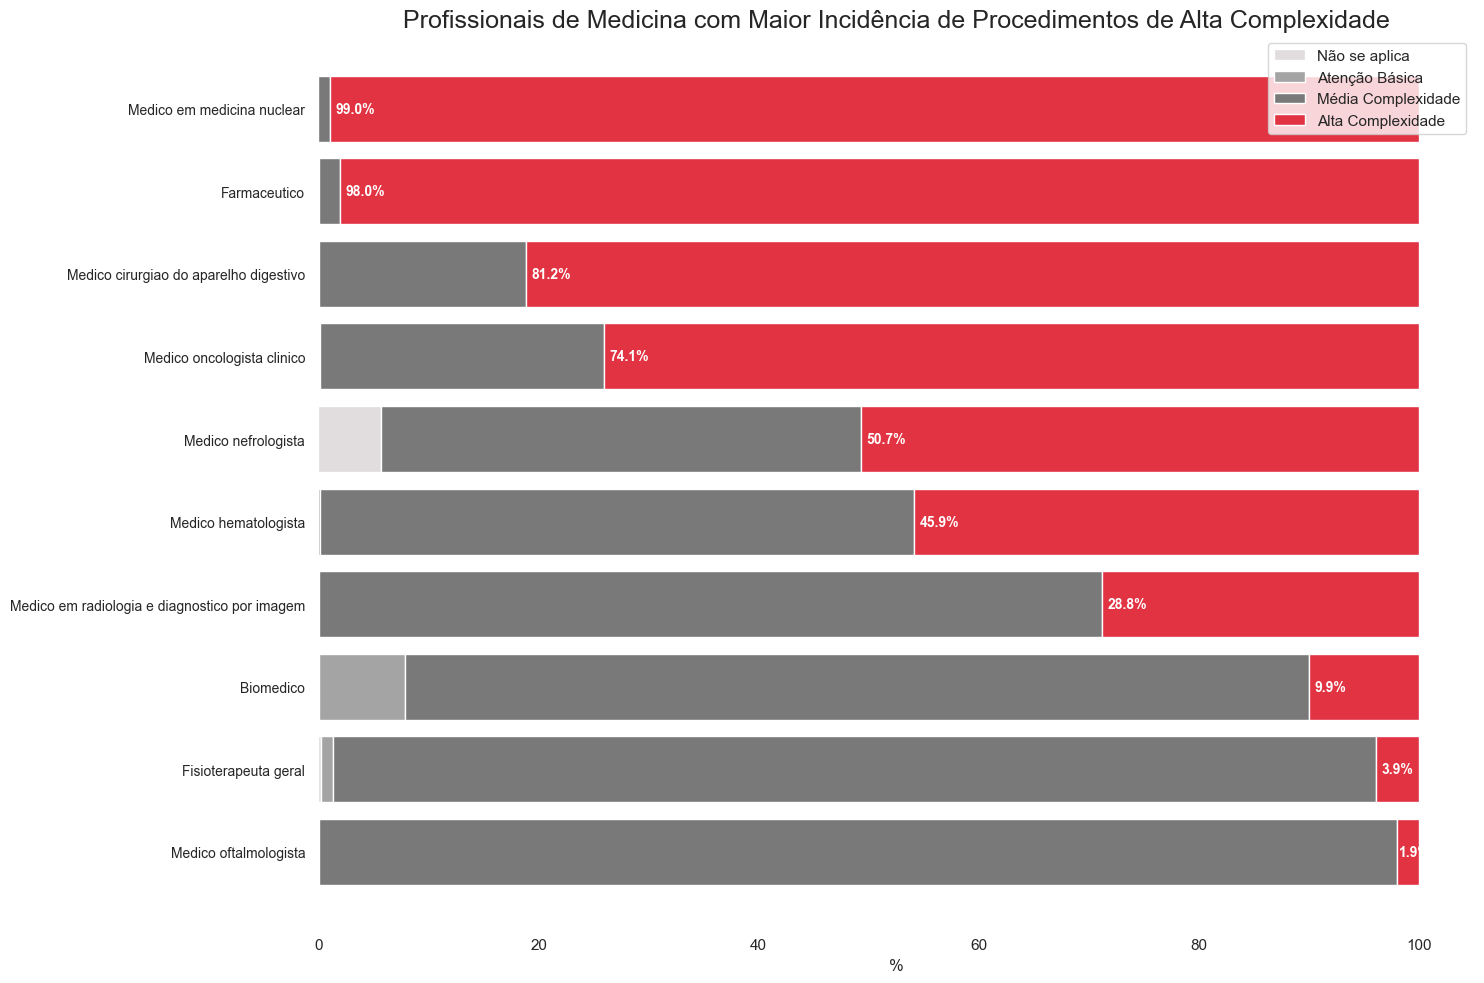

In [82]:
colors = ['#e1dcdd', '#a4a4a4', '#797979', '#e13342']

df_102 = spark.sql(SQL_102).toPandas()
df_112 = spark.sql(SQL_112).toPandas()

plt.figure(figsize=(15, 10))

sns.set_style("white", {
    'axes.spines.bottom': False, 'axes.spines.left': False,
    'axes.spines.right': False, 'axes.spines.top': False
})

bottom = np.zeros(len(df_102))
for i in range(4):
    plt.barh(df_102["DS_PA_CBOCOD"], df_102[f"PERC_NIVPL_{i}"],
             left=bottom, color=colors[i], label= df_112[df_112['PA_NIVCPL'] == i]['DS_PA_NIVCPL'].values[0] )
    bottom += df_102[f"PERC_NIVPL_{i}"]

plt.xlabel("%")
plt.title("Profissionais de Medicina com Maior Incidência de Procedimentos de Alta Complexidade", fontsize=18)
plt.yticks(range(len(df_102["DS_PA_CBOCOD"])), df_102["DS_PA_CBOCOD"], fontsize=10)
plt.legend()

plt.gca().invert_yaxis()

length_df_102 = len(df_102["PERC_NIVPL_3"])
for i, perc in enumerate(df_102["PERC_NIVPL_3"]):
    if i < length_df_102-1:
        plt.text(100.5 - perc, i, f"{perc:.1f}%", ha='left', va='center', fontsize=10, fontweight="bold", color="white")
    else:
        plt.text(100.1 - perc, i, f"{perc:.1f}%", ha='left', va='center', fontsize=10, fontweight="bold", color="white")

plt.tight_layout()

plt.show()

In [78]:
num_results = 5

SQL_103 = f'''
WITH TOP_{num_results}_COEF_VARIACAO AS (
       SELECT SSS.PA_CBOCOD
            , (AVG(DP_QTD_PROC) / AVG(MEDIA_QTD_PROC)) AS COEF_VARIACAO
         FROM (
              SELECT SS.PA_CBOCOD 
                   , SQRT(VARIANCE(SS.QTD_PROC)) AS DP_QTD_PROC
                   , AVG(SS.QTD_PROC)            AS MEDIA_QTD_PROC
                FROM (
                     SELECT S.PA_CBOCOD
                          , S.DS_PA_CBOCOD
                          , EXTRACT(MONTH FROM S.PA_CMP) AS MES
                          , COUNT(1)                     AS QTD_PROC
                       FROM VW_SIA S
                      WHERE 1=1
                        AND EXTRACT(YEAR FROM S.PA_CMP) NOT IN (2020, 2023)
                      GROUP BY S.PA_CBOCOD
                             , DS_PA_CBOCOD
                             , EXTRACT(MONTH FROM S.PA_CMP)
                     HAVING COUNT(1) > 100000
                     ) SS
              GROUP BY SS.PA_CBOCOD
              ) SSS
       GROUP BY SSS.PA_CBOCOD
       ORDER BY 2 DESC
       LIMIT {num_results}
)

SELECT S.PA_CBOCOD
     , S.DS_PA_CBOCOD
     , EXTRACT(MONTH FROM S.PA_CMP) AS MES 
     , DATE_FORMAT(S.PA_CMP, 'MMM') AS MES_ABREV
     , COUNT(1) AS QTD_PROC
  FROM VW_SIA S
 WHERE 1=1
   AND EXISTS (
       SELECT 1
         FROM TOP_{num_results}_COEF_VARIACAO D
        WHERE D.PA_CBOCOD = S.PA_CBOCOD
   )
 GROUP BY S.PA_CBOCOD
        , S.DS_PA_CBOCOD
        , EXTRACT(MONTH FROM S.PA_CMP)
        , DATE_FORMAT(S.PA_CMP, 'MMM')
 ORDER BY 1 , 3
'''

Nesta análise, foram selecionados profissionais que apresentaram mais de 100 mil atendimentos entre os anos de 2021 e 2022 (anos em que temos registros completos de janeiro à dezembro). Além disso, considerou-se como critério de análise os cinco profissionais com maior resultado no indicador de coeficiente de variação entre os meses.<br>

Uma observação importante é a drástica diminuição na quantidade de atendimentos a partir do mês de setembro. Entre os profissionais selecionados, o médico oftalmologista se destacou com o maior número de atendimentos ao longo do período, com uma média mensal superior a 400 mil procedimentos. No entanto, é notável que sua carga de trabalho também sofreu uma queda acentuada a partir de Setembro.<br>

Os outros quatro profissionais, Farmacêutico, Enfermeiro, Fisioterapeuta geral e Médico em radiologia e diagnóstico por imagem, também tiveram um número significativo de atendimentos, mas experimentaram quedas similares em Setembro. Suas cargas de trabalho, embora tenham variado mês a mês, demonstraram uma tendência de queda.

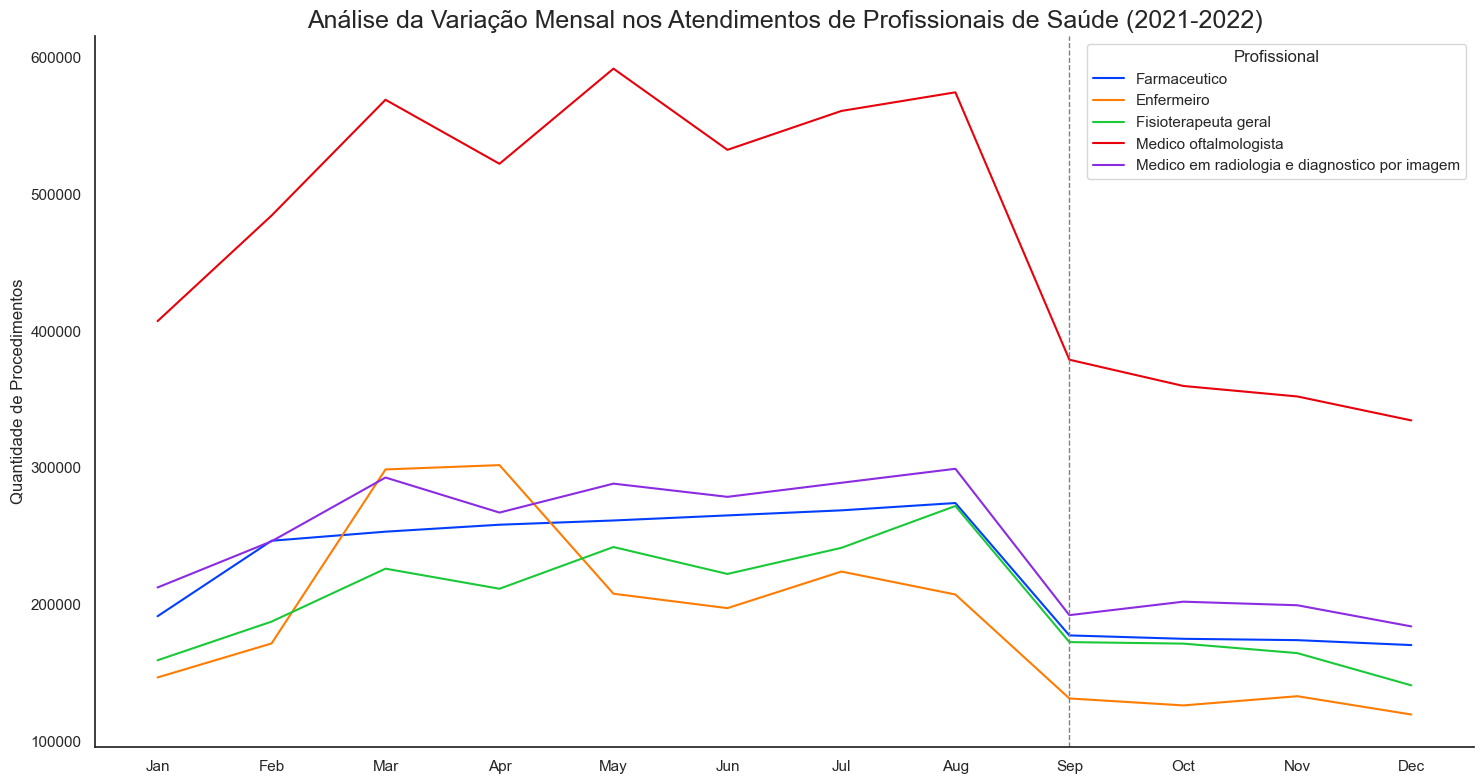

In [188]:
df_103 = spark.sql(SQL_103).toPandas()

sns.set_style("white", {
    'axes.spines.bottom': True, 'axes.spines.left': True,
    'axes.spines.right': False, 'axes.spines.top': False
})

plt.figure(figsize=(15, 8))
sns.lineplot(data=df_103, x='MES', y='QTD_PROC', hue='DS_PA_CBOCOD', palette = sns.color_palette('bright', num_results))

plt.axvline(x=9, color='gray', linestyle='--', linewidth=1)

plt.title('Análise da Variação Mensal nos Atendimentos de Profissionais de Saúde (2021-2022)', fontsize=18)
plt.xlabel('')
plt.ylabel('Quantidade de Procedimentos')
plt.xticks(range(1, 13), df_103['MES_ABREV'].unique())

plt.legend(title='Profissional')

plt.tight_layout()
plt.show()


# Desafio 2: Análise de Valores e Quantidades em Atendimentos de Saúde em Pernambuco

In [280]:
QTD_TOTAL_PROC  = spark.sql('''SELECT COUNT(1) AS QTD_PROC FROM VW_SIA''').toPandas()['QTD_PROC'][0]
QTD_TOTAL_UFMUN = spark.sql('''SELECT COUNT( DISTINCT PA_UFMUN ) AS QTD_UFMUN FROM VW_SIA''').toPandas()['QTD_UFMUN'][0]
MIN_DATA        = spark.sql('''SELECT MIN(PA_CMP) AS MIN_DATA FROM VW_SIA''').toPandas()['MIN_DATA'][0]
MAX_DATA        = spark.sql('''SELECT MAX(PA_CMP) AS MAX_DATA FROM VW_SIA''').toPandas()['MAX_DATA'][0]

QTD_TOTAL_PROC, QTD_TOTAL_UFMUN, MIN_DATA, MAX_DATA

(33831473, 185, datetime.date(2020, 9, 1), datetime.date(2023, 8, 1))

Para melhorar a análise dos gráficos posteriores, foi obtido o rank de quantidade de procedimentos realizados e valor total para pagamento pelas Secretarias de Saúde.

In [246]:
SQL_201 = ''' 
SELECT *
  FROM (
          SELECT PA_UFMUN
               , DS_PA_UFMUN
               , PA_VALAPR
               , PERC_QTD
               , RANK_PA_VALAPR
               , ROW_NUMBER() OVER (ORDER BY PERC_QTD DESC) AS RANK_PERC_QTD
          FROM (
               SELECT PA_UFMUN
                    , DS_PA_UFMUN
                    , PA_VALAPR
                    , ROUND( (PA_QTD / {}*100), 4) AS PERC_QTD
                    , ROW_NUMBER() OVER (ORDER BY PA_VALAPR DESC) AS RANK_PA_VALAPR
               FROM (
                    SELECT PA_UFMUN
                         , DS_PA_UFMUN
                         , COUNT(1)       AS PA_QTD
                         , SUM(PA_VALAPR) AS PA_VALAPR
                         FROM VW_SIA
                         GROUP BY PA_UFMUN
                              ,  DS_PA_UFMUN
                    )
               )
     )
 ORDER BY RANK_PERC_QTD
'''

df_201 = spark.sql(SQL_201.format(QTD_TOTAL_PROC)).toPandas()
df_201.head(10)


,PA_UFMUN,DS_PA_UFMUN,PA_VALAPR,PERC_QTD,RANK_PA_VALAPR,RANK_PERC_QTD
0,261160,RECIFE,1.450380e+09,44.9185,1,1
1,260790,JABOATAO DOS GUARARAPES,1.413548e+08,4.8050,3,2
2,260410,CARUARU,1.513027e+08,3.8992,2,3
3,260600,GARANHUNS,9.532936e+07,3.1933,4,4
4,260120,ARCOVERDE,5.715784e+07,2.2423,8,5
5,261110,PETROLINA,9.381056e+07,2.2320,5,6
6,261070,PAULISTA,5.670764e+07,2.0319,9,7
7,260290,CABO DE SANTO AGOSTINHO,7.054085e+07,2.0238,6,8
8,260960,OLINDA,5.568157e+07,1.7058,10,9
9,261640,VITORIA DE SANTO ANTAO,4.956479e+07,1.6490,11,10


A apresentação dos cinco gráficos violinplot oferece uma visão abrangente da distribuição dos valores pagos aprovados para pagamento pelas Secretarias de Saúde nos municípios. Ao dividir os municípios em diferentes quartis, podemos observar como os valores variam em relação aos diferentes níveis de desempenho financeiro.

In [281]:
def mount_violin_sql_201(rank_valapr_min = 1, rank_valapr_max = QTD_TOTAL_UFMUN,
                         rank_perc_qtd_min = 1 , rank_perc_qtd_max = QTD_TOTAL_UFMUN,
                         title = ''):
     
    df_201_tmp = df_201[(df_201['RANK_PA_VALAPR'] >= rank_valapr_min) &
                (df_201['RANK_PA_VALAPR'] <= rank_valapr_max) &
                (df_201['RANK_PERC_QTD'] >= rank_perc_qtd_min) &
                (df_201['RANK_PERC_QTD'] <= rank_perc_qtd_max)]

    sns.set_style("white", {
    'axes.spines.bottom': True, 'axes.spines.left': True,
    'axes.spines.right': False, 'axes.spines.top': False
    })

    plt.figure(figsize=(12, 6))

    violinplot = sns.violinplot(x=df_201_tmp["PA_VALAPR"], color='#5d998d')
    plt.xlabel("Valor Pago")
    plt.ylabel("")

    plt.suptitle(f"Distribuição do Somatório de Valor Pago por Município ({MIN_DATA.strftime('%b/%Y')} - {MAX_DATA.strftime('%b/%Y')})",
                 fontweight='bold')
    plt.title(title)

    def millions(x, pos):
        return f'{x / 1e6:.1f} mi'

    formatter = ticker.FuncFormatter(millions)
    violinplot.xaxis.set_major_formatter(formatter)

    plt.tight_layout()
    plt.show()

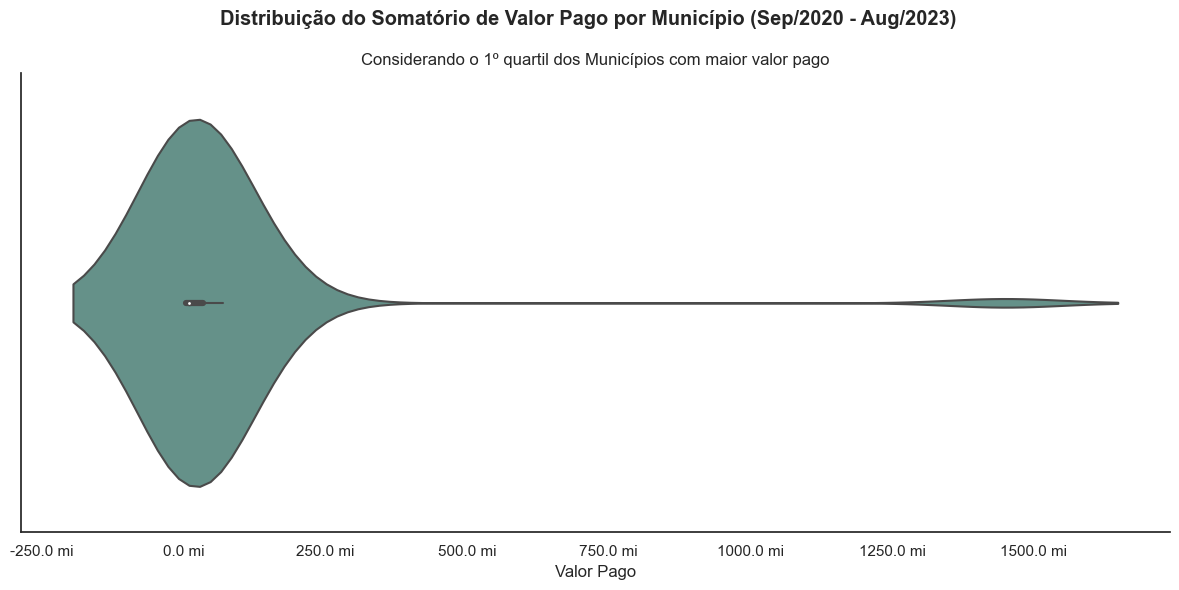

In [282]:
mount_violin_sql_201(rank_valapr_max = int(QTD_TOTAL_UFMUN*0.25),
                     title='Considerando o 1º quartil dos Municípios com maior valor pago')

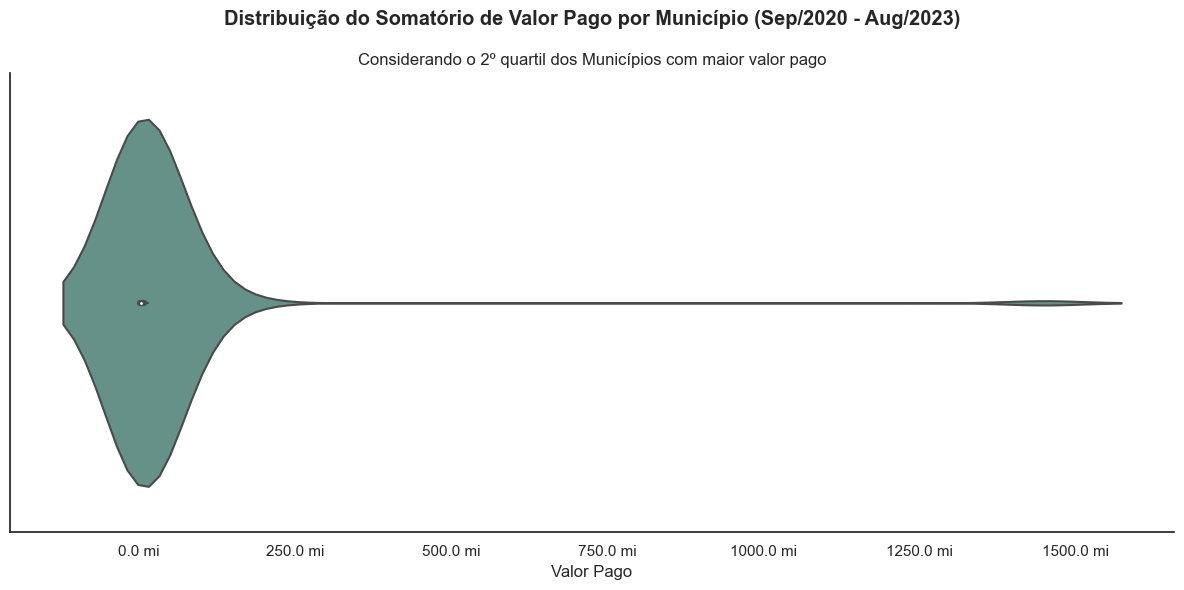

In [283]:
mount_violin_sql_201(title='Considerando o 2º quartil dos Municípios com maior valor pago',
                     rank_valapr_max = int(QTD_TOTAL_UFMUN*0.50))

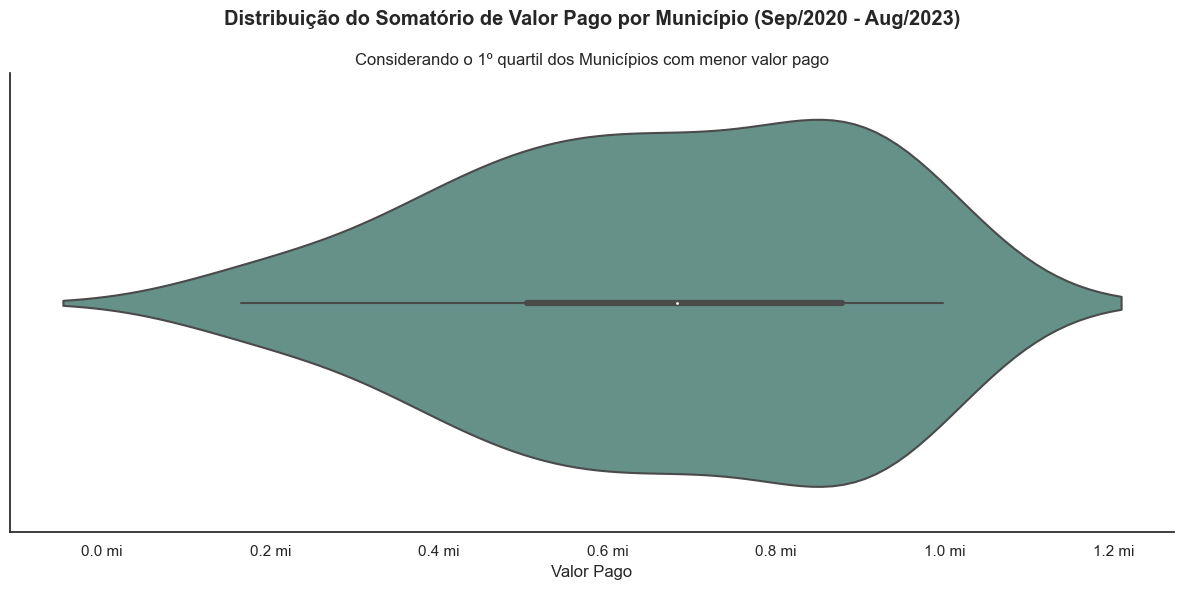

In [284]:
mount_violin_sql_201(title='Considerando o 1º quartil dos Municípios com menor valor pago',
                     rank_valapr_min = int(QTD_TOTAL_UFMUN*0.75))

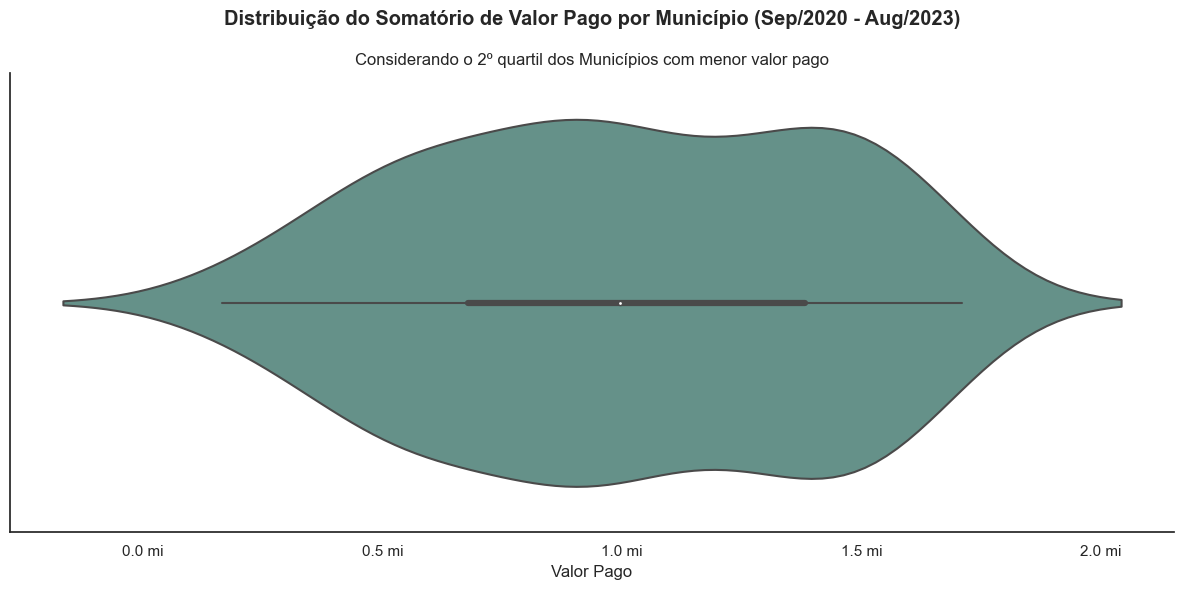

In [285]:
mount_violin_sql_201(title='Considerando o 2º quartil dos Municípios com menor valor pago',
                     rank_valapr_min = int(QTD_TOTAL_UFMUN*0.5))

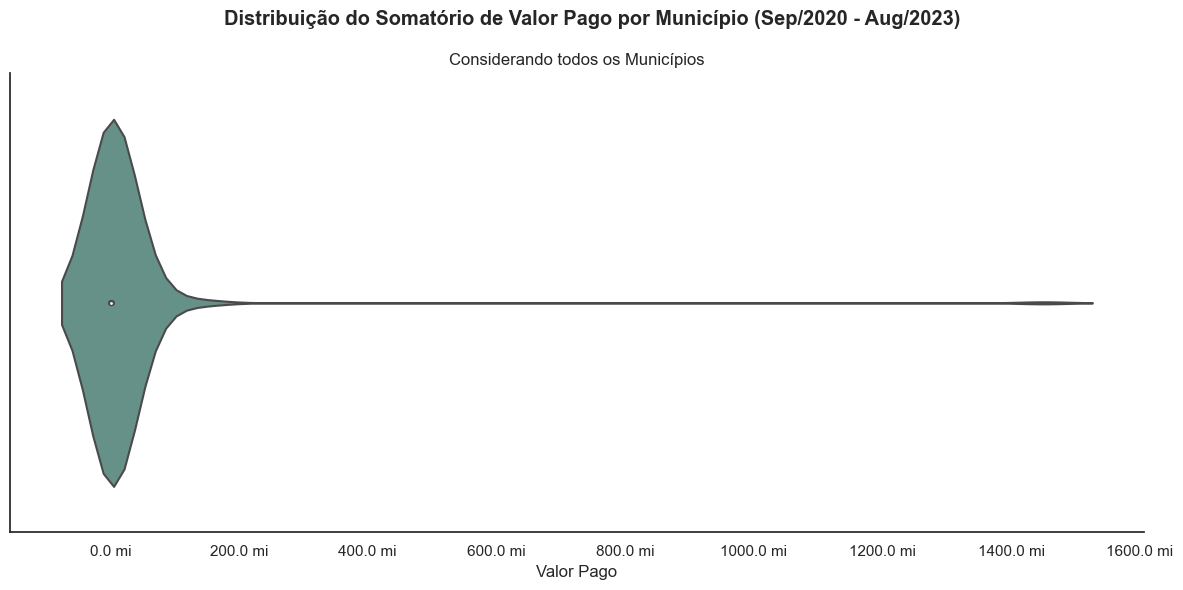

In [286]:
mount_violin_sql_201(title='Considerando todos os Municípios')

A apresentação dos gráficos de dispersão, que comparam os atendimentos com o valor pago por município, oferece uma visão das tendências nos dados de saúde. A seleção dos municípios com base no valor pago e na quantidade de atendimentos permite uma análise mais detalhada das principais contribuições e desempenho em relação a essas métricas. A exclusão de Recife desses gráficos se deu ao fato de que Recife é considerado um outlier, tanto em termos de valor pago quanto de quantidade de atendimentos, o que poderia dificultar a análise dos demais municípios. Com esses gráficos é possível destacar padrões e variações em uma escala mais gerenciável.

In [298]:
SQL_202 = ''' 
SELECT PA_UFMUN
    , DS_PA_UFMUN
    , PA_QTD
    , PA_VALAPR
  FROM (
        SELECT PA_UFMUN
             , DS_PA_UFMUN
             , COUNT(1)       AS PA_QTD
             , SUM(PA_VALAPR) AS PA_VALAPR
          FROM VW_SIA
         GROUP BY  PA_UFMUN
                 , DS_PA_UFMUN
        )
'''

In [367]:
def mount_scatter_202(rank, ascending, num_result=5, ignore_ds_pa_ufmun=[]):
    '''rank: RANK_PA_VALAPR or RANK_PERC_QTD | order_by: True or False'''
    df_202 = spark.sql(SQL_202).toPandas()

    df_201_tmp = df_201[~df_201['DS_PA_UFMUN'].isin(ignore_ds_pa_ufmun)]
    df_202_tmp = df_202.merge(df_201_tmp, on='PA_UFMUN', how='inner')\
                       .sort_values(by=rank, ascending=ascending)\
                       .head(num_result)

    title_describe = {'rank': {'RANK_PA_VALAPR': 'Valor Pago', 'RANK_PERC_QTD': 'Quantidade de Atendimentos'},
                      'ascending': {True: 'maior', False: 'menor'}}
    title_ufmun_ignore = '(ignorando '+', '.join(ignore_ds_pa_ufmun)+')' if ignore_ds_pa_ufmun else ''

    plt.figure(figsize=(15, 8))

    scatterplot = sns.scatterplot(data=df_202_tmp, x="PA_QTD", y="PA_VALAPR_x", hue="DS_PA_UFMUN_x", palette=['black']*num_result)

    ax = plt.gca()
    formatter = ticker.StrMethodFormatter("{x:,.0f}")
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)

    plt.xlabel("Quantidade de Atendimentos")
    plt.ylabel("Valor Pago (R$)")

    plt.suptitle(f"Atendimentos vs. Valor Pago por Município ({MIN_DATA.strftime('%b/%Y')} - {MAX_DATA.strftime('%b/%Y')})", fontweight='bold')
    plt.title(f"Top {num_result} Municípios com {title_describe['ascending'][ascending]} {title_describe['rank'][rank]} {title_ufmun_ignore}", pad=20)

    for i in range(len(df_202)):
        plt.annotate(df_202['DS_PA_UFMUN'][i], (df_202['PA_QTD'][i], df_202['PA_VALAPR'][i]),
                    fontsize=10, fontweight="bold", xytext=(2, 2), textcoords='offset points')

    scatterplot.get_legend().remove()

    plt.axvline(x=df_202_tmp['PA_QTD'].mean(), color='gray', linestyle='--')
    plt.axhline(y=df_202_tmp['PA_VALAPR_x'].mean(), color='gray', linestyle='--')

    plt.tight_layout()
    plt.show()


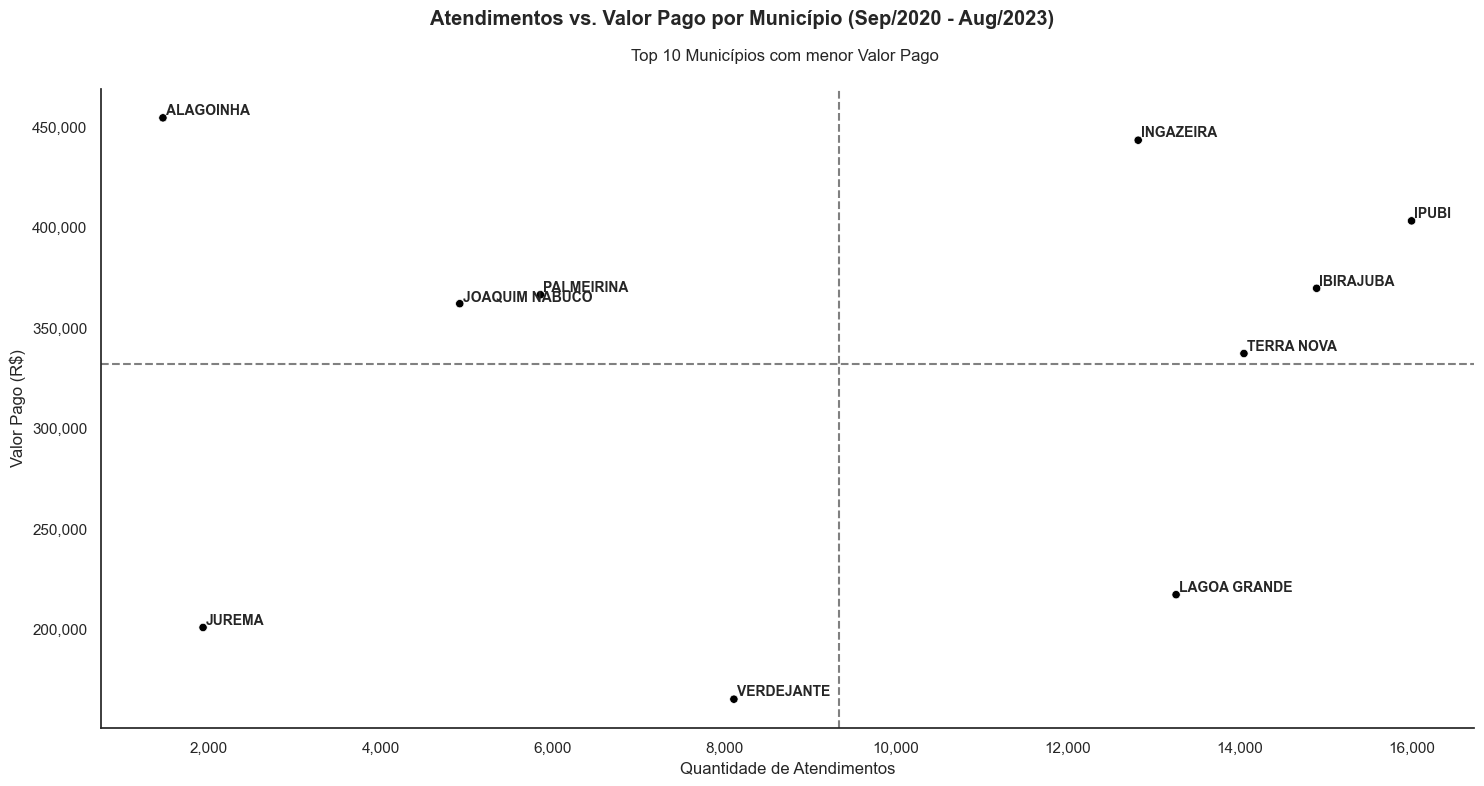

In [368]:
mount_scatter_202(rank='RANK_PA_VALAPR', ascending=False, num_result=10)

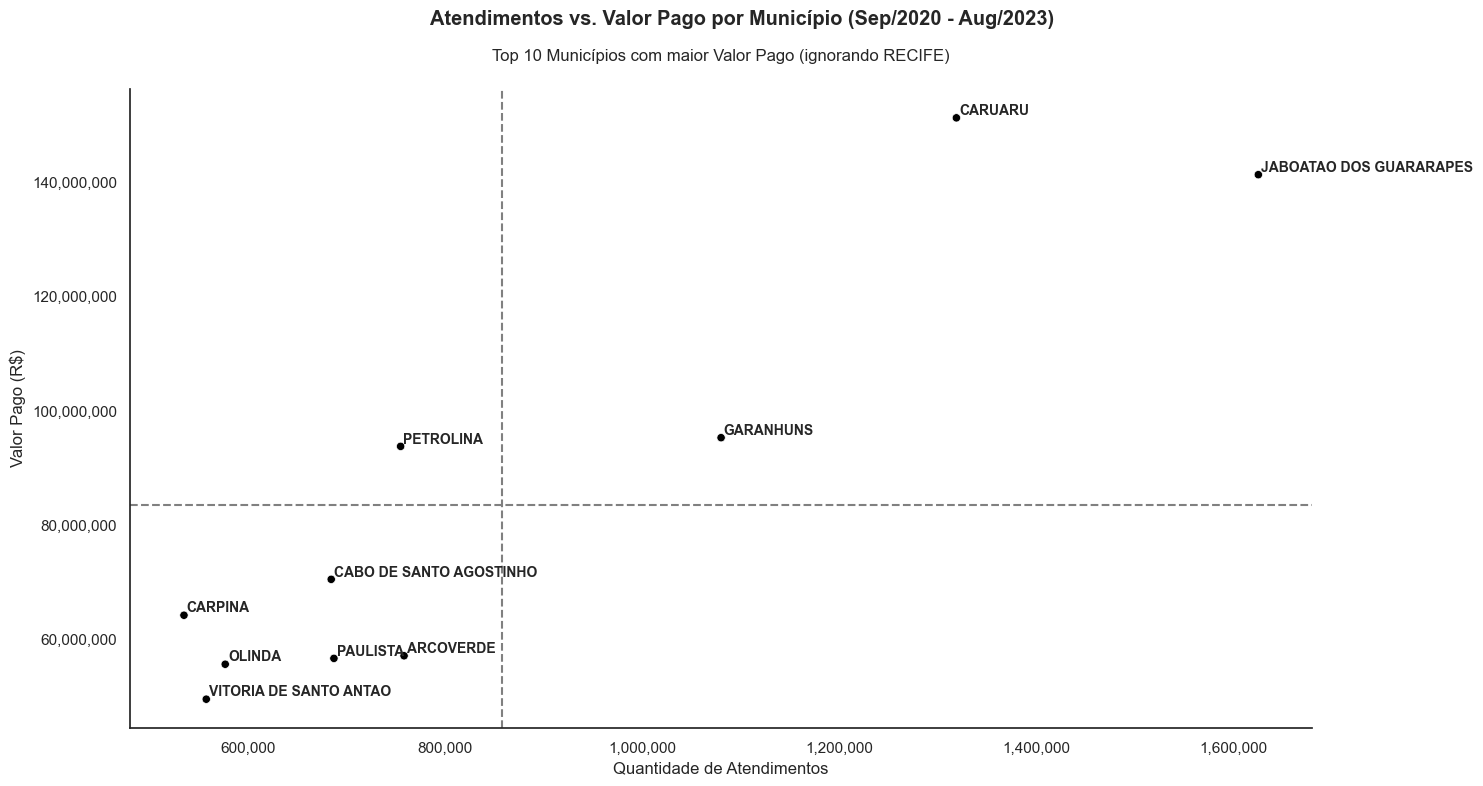

In [369]:
mount_scatter_202(rank='RANK_PA_VALAPR', ascending=True, num_result=10, ignore_ds_pa_ufmun=['RECIFE'])

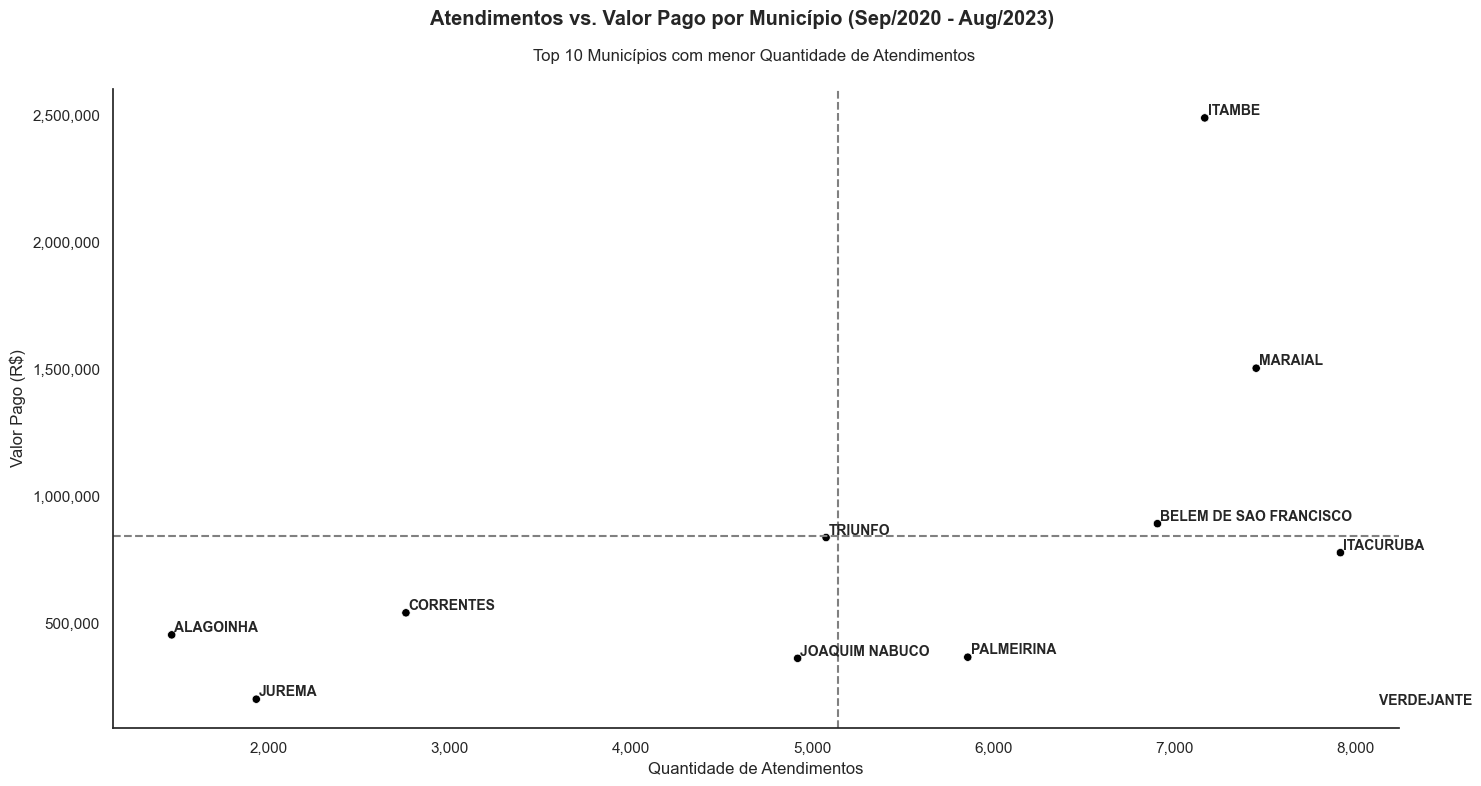

In [370]:
mount_scatter_202(rank='RANK_PERC_QTD', ascending=False, num_result=10)

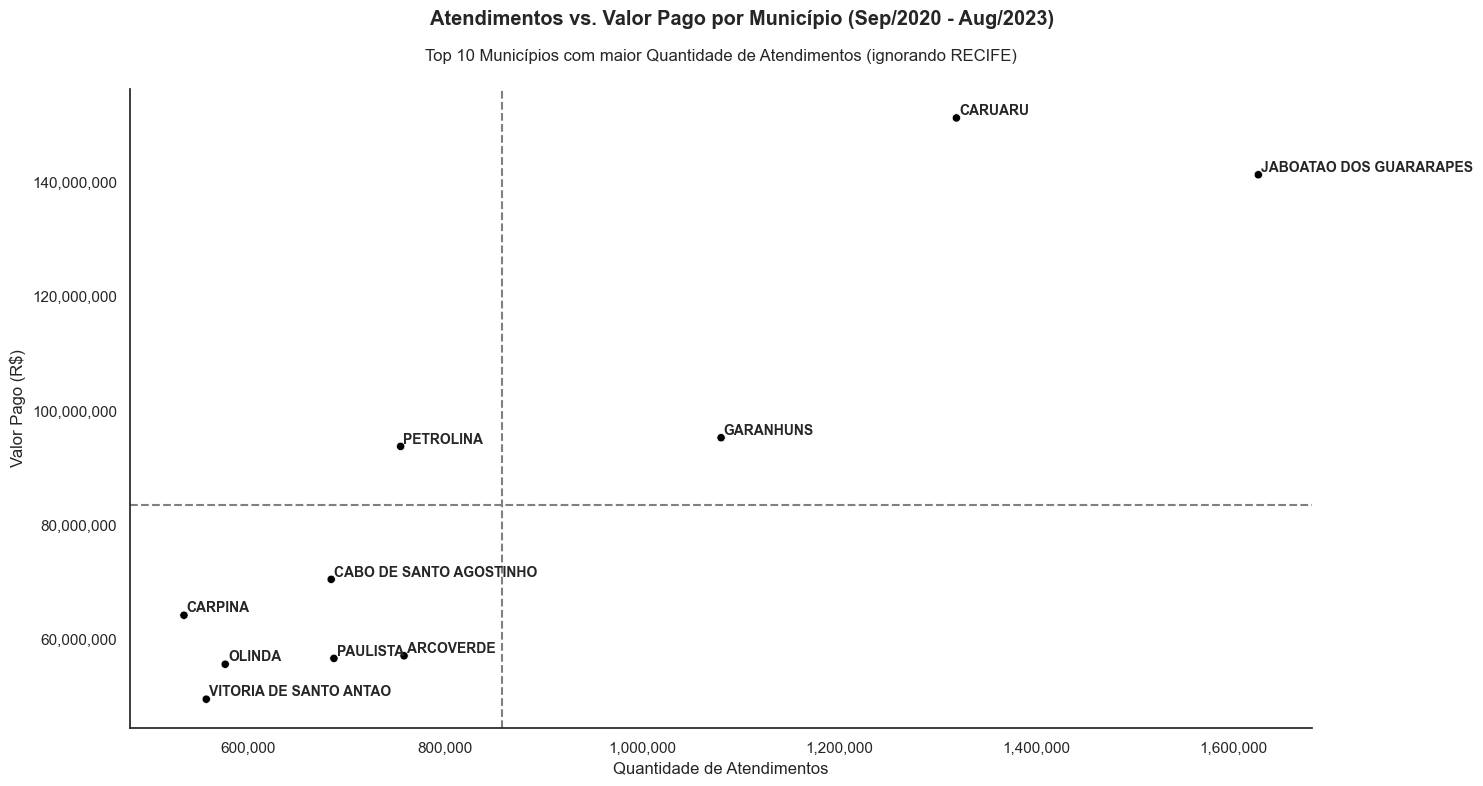

In [372]:
mount_scatter_202(rank='RANK_PERC_QTD', ascending=True, num_result=10, ignore_ds_pa_ufmun=['RECIFE'])

Mapa de Calor de Diferença de Valor: Use um mapa de calor para mostrar a diferença entre o valor pago e o valor esperado (com base na quantidade de atendimentos) em diferentes municípios. Isso pode destacar os municípios com variações significativas.

Gráfico de Barras de Municípios com Inconsistências: Crie um gráfico de barras que liste os municípios com as maiores inconsistências entre valor e quantidade de atendimentos. Isso pode ajudar a identificar os casos mais problemáticos.

Box Plot de Valores por Município: Use um box plot para visualizar a distribuição dos valores pagos em diferentes municípios. Isso pode revelar discrepâncias nos valores.

Gráfico de Linhas Temporais por Município: Se houver uma variável de data, crie um gráfico de linhas que mostre como a quantidade de atendimentos e os valores pagos variaram ao longo do tempo para diferentes municípios.

# Desafio 3: Análise da Distribuição de Valores, Mortalidade e Variáveis Temporais em Procedimentos de Saúde em Pernambuco

Gráfico de Correlação de Variáveis

Histograma da Distribuição dos Valores Pagos: Crie um histograma para visualizar a distribuição dos valores pagos por procedimento. Isso pode ajudar a identificar tendências na distribuição de custos.

Gráfico de Série Temporal de Atendimentos: Se houver dados de datas, crie um gráfico de série temporal que mostre como o número de atendimentos varia ao longo do tempo. Isso pode revelar tendências sazonais ou variações ao longo dos anos.

Gráfico de Pizza de Óbitos vs. Altas: Crie um gráfico de pizza para mostrar a proporção de procedimentos que resultaram em óbitos em comparação com aqueles que resultaram em altas. Isso pode fornecer insights sobre a mortalidade em relação aos procedimentos.

Gráfico de Pizza da Diferença de Município/UF por Complexidade: Use um gráfico de pizza para mostrar a proporção de pacientes que residem no mesmo município/UF do estabelecimento versus aqueles que residem em municípios/UF diferentes, segmentado por complexidade do procedimento.

Gráfico de Linhas Temporais da Diferença de Município: Se houver dados de datas, crie um gráfico de linhas que mostre como a diferença no município de residência do paciente em relação ao estabelecimento varia ao longo do tempo.